In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import torchvision.transforms
#imports pour faire le bouton pour charger les images utilisateurs
import tkinter
from tkinter import filedialog
from ipywidgets import widgets

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "train_vega"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

D:\Programs\conda\lib\site-packages\torchvision\transforms\transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
D:\Programs\conda\lib\site-packages\torchvision\transforms\transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


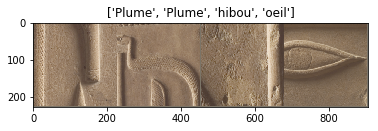

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [7]:
import torchvision.models
from torchvision.models.resnet import model_urls

model_urls['resnet18'] = model_urls['resnet18'].replace('https://', 'http://')

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc1 = nn.Linear(num_ftrs, 512)
model_ft.fc2 = nn.Linear(model_ft.fc1.in_features, 256)
model_ft.fc = nn.Linear(model_ft.fc2.in_features, 11) #Add a layer


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6098 Acc: 0.2281
val Loss: 0.5459 Acc: 0.3095

Epoch 1/24
----------
train Loss: 0.4438 Acc: 0.4386
val Loss: 0.4156 Acc: 0.3333

Epoch 2/24
----------
train Loss: 0.3807 Acc: 0.5614
val Loss: 0.2701 Acc: 0.6905

Epoch 3/24
----------
train Loss: 0.3200 Acc: 0.5614
val Loss: 0.3200 Acc: 0.6190

Epoch 4/24
----------
train Loss: 0.2698 Acc: 0.6842
val Loss: 0.2604 Acc: 0.7143

Epoch 5/24
----------
train Loss: 0.3392 Acc: 0.5614
val Loss: 0.2303 Acc: 0.7381

Epoch 6/24
----------
train Loss: 0.2519 Acc: 0.7018
val Loss: 0.2069 Acc: 0.7619

Epoch 7/24
----------
train Loss: 0.1907 Acc: 0.8421
val Loss: 0.2263 Acc: 0.7381

Epoch 8/24
----------
train Loss: 0.1804 Acc: 0.7895
val Loss: 0.2201 Acc: 0.7619

Epoch 9/24
----------
train Loss: 0.1689 Acc: 0.8246
val Loss: 0.2168 Acc: 0.7381

Epoch 10/24
----------
train Loss: 0.1652 Acc: 0.8421
val Loss: 0.2306 Acc: 0.7143

Epoch 11/24
----------
train Loss: 0.1796 Acc: 0.8246
val Loss: 0.2268 Acc: 0.6667

Ep

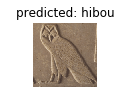

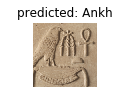

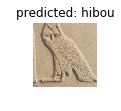

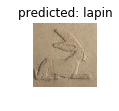

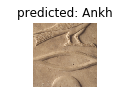

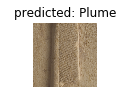

In [9]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [10]:
import tkinter
from tkinter import filedialog
import os

root = tkinter.Tk()
root.withdraw() #use to hide tkinter window

def clic(b):
    currdir = os.getcwd()
    tempdir = filedialog.askdirectory(parent=root, initialdir=currdir, title='Please select a directory')
    if len(tempdir) > 0:
        print ("You chose %s" % tempdir)
    files = next(os.walk(tempdir))[2]
    for f in files:
        print(tempdir+f)
        

In [17]:
#Test image
imsize = 256
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])
    
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

D:\Programs\conda\lib\site-packages\torchvision\transforms\transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [18]:
root = tkinter.Tk() #utilisation du package tkinter pour naviguer dans les dossiers
root.withdraw() #use to hide tkinter window

#function used to select a directory where the files are stored
def load(b):
    currdir = os.getcwd()
    tempdir = filedialog.askdirectory(parent=root, initialdir=currdir, title='Please select a directory')
    files = next(os.walk(tempdir))[2]
    for f in files:
        image = image_loader(os.path.join(tempdir, f))
        model_ft(image)

        outputs = model_ft(image)
        _, preds = torch.max(outputs.data, 1)

        print(class_names[preds[0]])

        print(outputs.data)
        print(class_names)

button = widgets.Button(description="Selectionner repertoire")
display(button)
button.on_click(load)

A Jupyter Widget

RuntimeError: size mismatch, m1: [1 x 7168], m2: [512 x 11] at d:\pytorch\pytorch\torch\lib\th\generic/THTensorMath.c:1416